# NuSTAR Timing Analysis: CTCV J2056-3014
### *To view plots, visit [nbviewer](https://nbviewer.org/github/ericymiao/ctcvj2056-timing-spin-evolution/blob/main/notebooks/03_nustar_timing.ipynb)*

Period searches for NuSTAR observations.

## NuSTAR-Specific Notes

NuSTAR (Nuclear Spectroscopic Telescope Array) provides focusing hard X-ray observations in the 3-79 keV band, extending well beyond the soft X-ray coverage of NICER and XMM-Newton. Key considerations:

- **Two focal plane modules (FPMA, FPMB)**: Each module has its own optics and detector, providing independent measurements. Both must be analyzed separately to verify consistent detections.
- **Hard X-ray coverage**: The 3-79 keV band probes higher-energy emission from the accretion column and WD surface, complementing the soft X-ray data.
- **Background extraction**: Like XMM, background is extracted from source-free regions on the detector and scaled by extraction area.

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
from stingray import EventList, Lightcurve
from stingray.pulse import z_n_search
from astropy.time import Time, TimeDelta
import hendrics.io as HENio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from timing_analysis import (
    fold, get_frequency_uncertainty, bayesian_periodogram
)
from statistics import (
    test_hardness_ratio_variability, test_phase_correlation
)

plt.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'figure.constrained_layout.use': True,
})

savedir = '../paper_figures'

## Load Data

In [2]:
# Load NuSTAR event files
events = {
    'FPMA': {'src': {}, 'bkg': {}},
    'FPMB': {'src': {}, 'bkg': {}},
}

data_path = '../../../nustar/30801006002/event_cl/nu30801006002'

for fpm in ['FPMA', 'FPMB']:
    events[fpm]['src']['total'] = HENio.load_events(f'{data_path}{fpm[-1]}01_cl_bary_src.evt')
    events[fpm]['bkg']['total'] = HENio.load_events(f'{data_path}{fpm[-1]}01_cl_bary_bkg.evt')

# Energy filtering (3-79 keV for NuSTAR)
for fpm in events:
    for region in events[fpm]:
        events[fpm][region]['total'].filter_energy_range([3, 79], inplace=True)
        events[fpm][region]['soft'] = events[fpm][region]['total'].filter_energy_range([3, 10])
        events[fpm][region]['hard'] = events[fpm][region]['total'].filter_energy_range([10, 79])

# Create lightcurves
lightcurves = {}
for fpm in events:
    lightcurves[fpm] = {}
    for region in events[fpm]:
        lightcurves[fpm][region] = {}
        for energy in events[fpm][region]:
            lightcurves[fpm][region][energy] = {}
            for dt in [1, 5, 20, 50, 100]:
                lightcurves[fpm][region][energy][dt] = events[fpm][region][energy].to_lc(dt=dt)

## Observation Summary

In [3]:
print("NuSTAR OBSERVATION SUMMARY\n")

for fpm in events:
    src_counts = len(events[fpm]['src']['total'].time)
    total_time = np.sum(events[fpm]['src']['total'].gti[:, 1] - events[fpm]['src']['total'].gti[:, 0])
    
    print(f"{fpm}:")
    print(f"  Total Time: {total_time/1000:.2f} ks")
    print(f"  Total Counts: {src_counts:,}")
    print()

NuSTAR OBSERVATION SUMMARY

FPMA:
  Total Time: 28.16 ks
  Total Counts: 2,417

FPMB:
  Total Time: 28.18 ks
  Total Counts: 2,287



Observation length: 0.6712962962962962963 days
frequency "resolution:" 1.7241379310344827586e-05


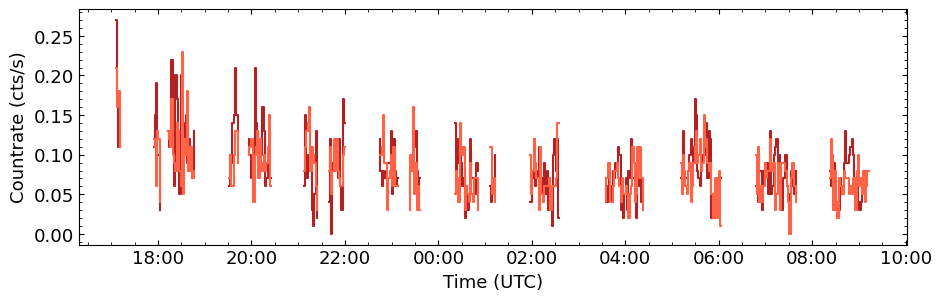

In [4]:
binsize = 100

fig, ax = plt.subplots(figsize=(9.3, 2.9))

for fpm in lightcurves:
    lc = lightcurves[fpm]['src']['total'][binsize]
    lc_time = np.asarray(lc.time, dtype=np.float64)
    lc_countrate = np.asarray(lc.countrate, dtype=np.float64)
    
    color = 'firebrick' if fpm == 'FPMA' else 'tomato'
    
    gti = np.asarray(lc.gti, dtype=np.float64) if lc.gti is not None else None
    if gti is not None:
        for gti_start, gti_stop in gti:
            mask = (lc_time >= gti_start) & (lc_time <= gti_stop)
            if not np.any(mask):
                continue
            t = Time(lc.mjdref, format='mjd') + TimeDelta(lc_time[mask], format='sec')
            x = t.to_datetime()
            ax.step(x, lc_countrate[mask], where='mid', color=color, lw=1.5)
    else:
        t = Time(lc.mjdref, format='mjd') + TimeDelta(lc_time, format='sec')
        x = t.to_datetime()
        cr = np.where(lc_countrate == 0, np.nan, lc_countrate)
        ax.step(x, cr, where='mid', color=color, lw=1.5)

ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Countrate (cts/s)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

obs_duration = (lc.time[-1]-lc.time[0])
print("Observation length:", obs_duration/86400, "days")
print("frequency \"resolution:\"", 1/obs_duration)

fig.savefig(f'{savedir}/nustar_lc.pdf')
plt.show()

## Z^2 Periodogram

Period search in the hard X-ray band. Each focal plane module is analyzed independently to confirm the pulsation detection at high energies.

Module: FPMA
FREQUENCY RESULTS:
  Peak:        3.377014652014652e-02 Hz
  Uncertainty: +6.349206e-06 / -6.349206e-06 Hz

PERIOD RESULTS:
  Peak:        2.961195324999322e+01 s
  Uncertainty: +5.568461e-03 / -5.566368e-03 s
Module: FPMB
FREQUENCY RESULTS:
  Peak:        3.376959706959707e-02 Hz
  Uncertainty: +5.067155e-06 / -5.189255e-06 Hz

PERIOD RESULTS:
  Peak:        2.961243505331323e+01 s
  Uncertainty: +4.551138e-03 / -4.442703e-03 s


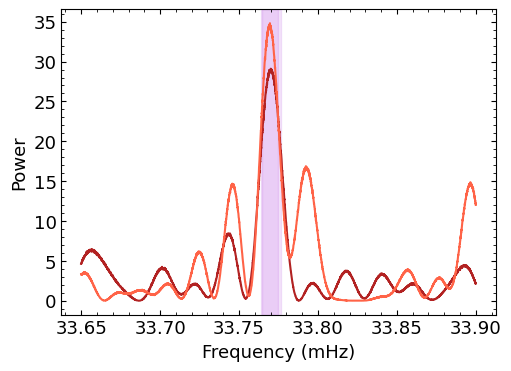

In [5]:
f_min, f_max = 0.03365, 0.0339
frequencies = np.linspace(f_min, f_max, 4096)
nharm = 1

Z2 = {}

fig, ax = plt.subplots(figsize=(5, 3.6))
for fpm in events:

    if fpm == 'FPMA':
            color = 'firebrick'
    elif fpm == 'FPMB':
            color = 'tomato'
    
    evt = events[fpm]['src']['total']
    frequency, power = z_n_search(evt.time, frequencies, nharm=nharm)
    Z2[fpm] = (frequency, power)
    
    ax.plot(frequency*1e3, power, lw=1.5, color=color)
    
    peak_freq = frequencies[np.argmax(power)]
    peak_power = power[np.argmax(power)]
    
    print(f"Module: {fpm}")
    freq_min, freq_max, power_min, _ = get_frequency_uncertainty(
        frequencies, power, peak_freq, peak_power, nharm, 1
    )
    
    ax.axvspan(freq_min*1e3, freq_max*1e3, alpha=0.1, color='darkviolet')
    #ax.axhline(power_min, alpha=0.8, color='darkviolet', ls='--')
    
    ax.set_xlabel('Frequency (mHz)')
    ax.set_ylabel('Power')
    ax.ticklabel_format(axis='x', useOffset=False)
    
    fig.savefig(f'{savedir}/nustar_z2_{fpm.lower()}.pdf')
plt.show()

## Folded Profiles

Phase-folded hard X-ray lightcurves in soft (3-10 keV) and hard (10-79 keV) bands. The pulse shape at hard X-rays may differ from soft X-rays if the emission mechanisms or viewing geometry differ with energy.

In [6]:
ephemeris = 58780
P_orb = 29.60968584
n_bins = 20

# Fold lightcurves
folded_lightcurves = {}
for fpm in events:
    folded_lightcurves[fpm] = {}
    for region in events[fpm]:
        folded_lightcurves[fpm][region] = {}
        for energy in events[fpm][region]:
            folded_lightcurves[fpm][region][energy] = fold(
                events[fpm][region][energy], P_orb, ephemeris, n_bins
            )

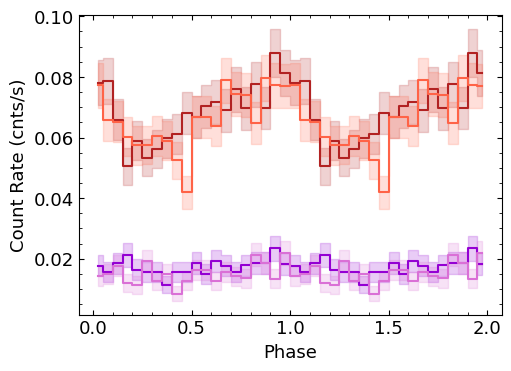

In [48]:
# Plot folded lightcurves
fig, ax = plt.subplots(figsize=(5, 3.6))
for fpm in folded_lightcurves:
    
    for energy in ['soft', 'hard']:

        if energy == 'soft':
            if fpm == 'FPMA': color = 'firebrick'
            elif fpm == 'FPMB': color = 'tomato'
        elif energy == 'hard':
            if fpm == 'FPMA': color = 'darkviolet'
            elif fpm == 'FPMB': color = 'orchid'
        
        phase, _, cr, err, _ = folded_lightcurves[fpm]['src'][energy]
        
        phase_centers = phase[1:] - np.diff(phase) / 2
        ext_phase = np.concatenate([phase_centers, phase_centers + 1])
        ext_cr = np.concatenate([cr, cr])
        ext_err = np.concatenate([err, err])
        
        ax.step(ext_phase, ext_cr, where='mid', color=color, lw=1.5)
        ax.fill_between(ext_phase, ext_cr - ext_err, ext_cr + ext_err,
                        step='mid', color=color, alpha=0.2)
    
    ax.set_xlabel('Phase')
    ax.set_ylabel('Count Rate (cnts/s)')
    
    fig.savefig(f'{savedir}/nustar_folded_softhard_{fpm.lower()}.pdf')
plt.show()

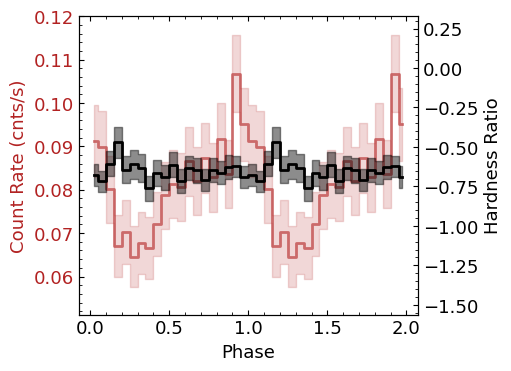

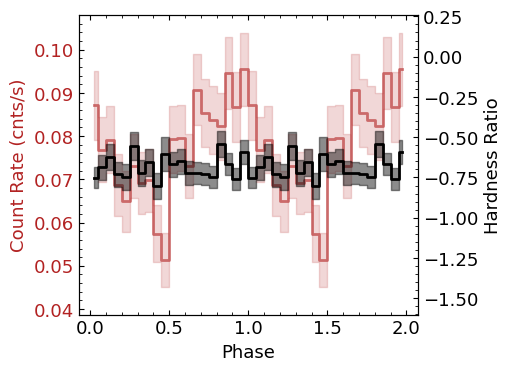

In [42]:
# Plot folded lightcurves with hardness ratios (total flux + HR dual axis)
HR = {}
HR_error = {}

# Background scaling factor (ratio of extraction areas)
# NuSTAR: source region radius 40", background region radius 200"
bkg_factor = (40**2) / (200**2)

for fpm in folded_lightcurves:
    # Background-subtracted soft and hard
    _, _, soft_cr, soft_err, _ = folded_lightcurves[fpm]['src']['soft']
    _, _, soft_bkg_cr, soft_bkg_err, _ = folded_lightcurves[fpm]['bkg']['soft']
    _, _, hard_cr, hard_err, _ = folded_lightcurves[fpm]['src']['hard']
    _, _, hard_bkg_cr, hard_bkg_err, _ = folded_lightcurves[fpm]['bkg']['hard']
    phase, _, total_cr, total_err, _ = folded_lightcurves[fpm]['src']['total']
    _, _, total_bkg_cr, total_bkg_err, _ = folded_lightcurves[fpm]['bkg']['total']

    soft_sub = soft_cr - soft_bkg_cr * bkg_factor
    soft_sub_err = np.sqrt(soft_err**2 + (soft_bkg_err * bkg_factor)**2)
    hard_sub = hard_cr - hard_bkg_cr * bkg_factor
    hard_sub_err = np.sqrt(hard_err**2 + (hard_bkg_err * bkg_factor)**2)
    total_sub = total_cr - total_bkg_cr * bkg_factor
    total_sub_err = np.sqrt(total_err**2 + (total_bkg_err * bkg_factor)**2)

    phase_centers = phase[1:] - np.diff(phase) / 2
    ext_phase = np.concatenate([phase_centers, phase_centers + 1])

    # --- Dual-axis: flux + HR ---
    fig, ax = plt.subplots(figsize=(5, 3.6))

    ext_total = np.concatenate([total_sub, total_sub])
    ext_total_err = np.concatenate([total_sub_err, total_sub_err])

    ax.step(ext_phase, ext_total, where='mid', color='firebrick', lw=2, alpha=0.6)
    ax.fill_between(ext_phase, ext_total - ext_total_err, ext_total + ext_total_err,
                    step='mid', color='firebrick', alpha=0.18)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Count Rate (cnts/s)', color='firebrick')
    ax.tick_params(axis='y', labelcolor='firebrick')

    rate_min = np.min(total_sub) - 1.5 * np.max(total_sub_err)
    rate_max = np.max(total_sub) + 1.5 * np.max(total_sub_err)
    ax.set_ylim(rate_min, rate_max)

    # Hardness ratio on right axis
    hr = (hard_sub - soft_sub) / (hard_sub + soft_sub)
    hr_err = (2 * np.sqrt(hard_sub**2 * soft_sub_err**2 + soft_sub**2 * hard_sub_err**2)) / (hard_sub + soft_sub)**2
    HR[fpm] = hr
    HR_error[fpm] = hr_err

    ext_hr = np.concatenate([hr, hr])
    ext_hr_err = np.concatenate([hr_err, hr_err])

    ax2 = ax.twinx()
    ax2.step(ext_phase, ext_hr, where='mid', color='black', lw=2)
    ax2.fill_between(ext_phase, ext_hr - ext_hr_err, ext_hr + ext_hr_err,
                     step='mid', color='black', alpha=0.45)
    ax2.set_ylabel('Hardness Ratio')

    hr_min = np.min(hr) - 2 * 0.4
    hr_max = np.max(hr) + 2 * 0.4
    ax2.set_ylim(hr_min, hr_max)

    fig.savefig(f'{savedir}/nustar_folded_hr_{fpm.lower()}.pdf')
    plt.show()

## Statistical Tests

### F-test for Hardness Ratio Variability

Testing whether the hardness ratio varies sinusoidally with pulse phase. The null hypothesis assumes constant HR; the alternative fits a sinusoid. A significant F-statistic indicates genuine spectral variability with phase.

### Phase Correlation Test

Determines whether HR is correlated or anticorrelated with flux (i.e., does the source harden when brighter or fainter?).

In [9]:
fpms = ['FPMA', 'FPMB']

print("F-TEST FOR HARDNESS RATIO VARIABILITY\n")

for fpm in fpms:
    print(f"MODULE: {fpm}")
    result = test_hardness_ratio_variability(HR[fpm], HR_error[fpm])
    print()

F-TEST FOR HARDNESS RATIO VARIABILITY

MODULE: FPMA

Model 1 (Constant): chi2 = 9.54, dof = 19, chi2_red = 0.50
Model 2 (Sinusoid): chi2 = 9.18, dof = 17, chi2_red = 0.54
  Offset: -0.6587 +/- 0.0174
  Amplitude: 0.0146 +/- 0.0244
  Phase shift: 0.128 cycles

F-test: F = 0.34, p = 7.20e-01, 0.4 sigma
Result: No significant improvement

MODULE: FPMB

Model 1 (Constant): chi2 = 15.43, dof = 19, chi2_red = 0.81
Model 2 (Sinusoid): chi2 = 15.35, dof = 17, chi2_red = 0.90
  Offset: -0.6905 +/- 0.0172
  Amplitude: 0.0068 +/- 0.0239
  Phase shift: 0.125 cycles

F-test: F = 0.05, p = 9.56e-01, 0.1 sigma
Result: No significant improvement



In [10]:
print("PHASE CORRELATION TEST: HARDNESS RATIO vs FLUX\n")

for fpm in fpms:
    print(f"MODULE: {fpm}")
    _, _, flux_data, flux_errors, _ = folded_lightcurves[fpm]['src']['total']
    result = test_phase_correlation(flux_data, flux_errors, HR[fpm], HR_error[fpm])
    print()

PHASE CORRELATION TEST: HARDNESS RATIO vs FLUX

MODULE: FPMA

HR amplitude: 0.0146 +/- 0.0244 (0.6 sigma)
Flux amplitude: 0.0124 +/- 0.0024 (5.1 sigma)

Flux max at phase: 0.849 +/- 0.0318
HR max at phase: 0.122 +/- 0.2677
Phase difference: 0.273 +/- 0.2695 cycles

Deviation from in-phase (delta_phi=0): 1.0 sigma
Deviation from anticorr (|delta_phi|=0.5): 0.8 sigma
Result: ANTICORRELATED - HR max aligns with flux min

MODULE: FPMB

HR amplitude: 0.0068 +/- 0.0239 (0.3 sigma)
Flux amplitude: 0.0138 +/- 0.0024 (5.8 sigma)

Flux max at phase: 0.879 +/- 0.0276
HR max at phase: 0.125 +/- 0.5723
Phase difference: 0.246 +/- 0.5730 cycles

Deviation from in-phase (delta_phi=0): 0.4 sigma
Deviation from anticorr (|delta_phi|=0.5): 0.4 sigma
Result: IN PHASE - HR max aligns with flux max

